# MNIST

In [6]:
from sklearn.datasets import fetch_openml

# 사이킷런 1.2에서 추가된 parser 매개변수 기본값이 1.4 버전에서 'liac-arff'에서 'auto'로 바뀝니다.
# 'auto'일 경우 희소한 ARFF 포맷일 때는 'liac-arff', 그렇지 않을 때는 'pandas'가 됩니다.
# 이에 대한 경고를 피하려면 parser='auto'로 지정하세요.
mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
mnist.keys()  # 추가 코드 - 이 노트북에서는 data와 target만 사용합니다

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [40]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
X.shape

(70000, 784)

In [56]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [43]:
y.shape

(70000,)

In [44]:
28 * 28

784

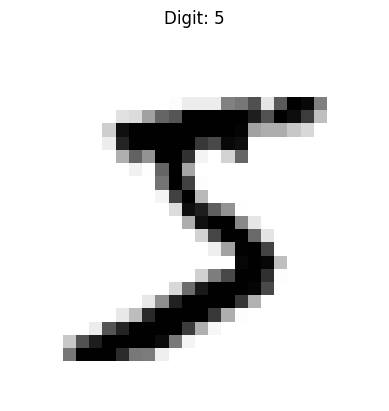

In [55]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.title(f"Digit: {y[0]}")
plt.show()

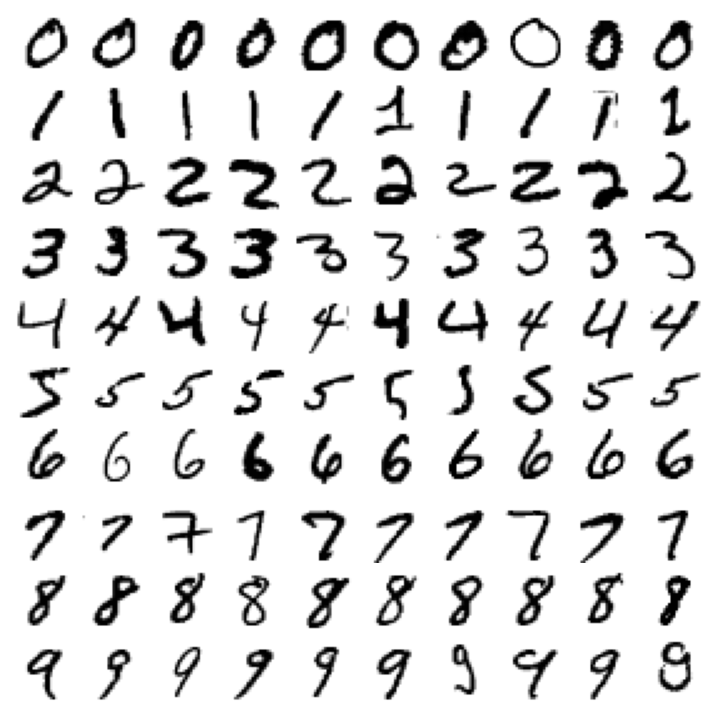

In [71]:
import numpy as np
index = [np.where(y == str(i))[0][:10] for i in range(10)]
y[index]
plt.figure(figsize=(9, 9))

count = 1
for row in X[index]:
  for image_data in row:
      plt.subplot(10, 10, count)
      count += 1
      plot_digit(image_data)
      plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [73]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류기 훈련

In [74]:
y_train_5 = (y_train == '5')  # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == '5')

In [80]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [81]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

## 교차 검증을 사용한 정확도 측정

In [82]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [83]:
# StratifiedKFold
# 클래스의 분포가 동일하지 않으면 클래스 불균형이 나타나고 교차검증할때 클래스의 비율이 일관되게 분포
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True)  # 데이터셋이 미리 섞여 있지 않다면
                                       # shuffle=True를 추가하세요.
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9657
0.95795
0.96865


In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [ ]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

## 오차 행렬

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## 정밀도와 재현율

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [ ]:
# 추가 코드 – TP / (FP + TP) 식으로 정밀도를 계산합니다
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [ ]:
# 추가 코드 – TP / (FN + TP) 식으로 정밀도를 계산합니다
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
# 추가 코드 – f1 점수를 계산합니다
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## 정밀도/재현율 트레이드오프

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

array([ True])

In [ ]:
# 추가 코드 – y_scores > 0이면 predict()를 호출하는 것과 같은 결과를 냅니다
y_scores > 0

array([ True])

In [ ]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
thresholds, precisions

(array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
          38871.26391927,   42216.05562787,   49441.43765905]),
 array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
        1.        ]))

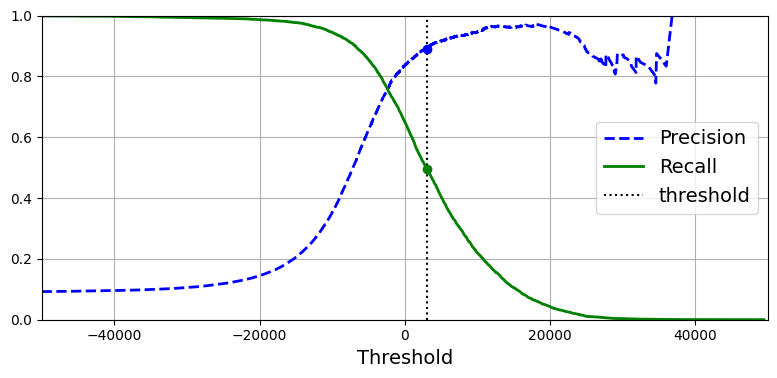

In [ ]:
plt.figure(figsize=(8, 4))  # 추가 코드
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# 추가 코드 – 그림 3–5를 그리고 저장합니다
idx = (thresholds >= threshold).argmax()  # 첫 번째 index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

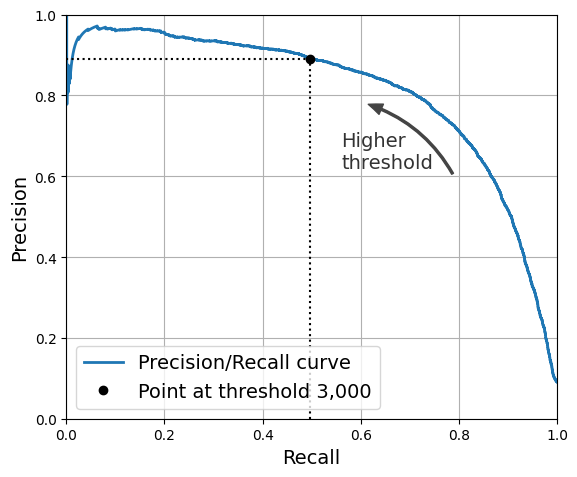

In [ ]:
import matplotlib.patches as patches  # 추가 코드 – 구부러진 화살표를 그리기 위해서

plt.figure(figsize=(6, 5))  # 추가 코드

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [ ]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## ROC 곡선

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

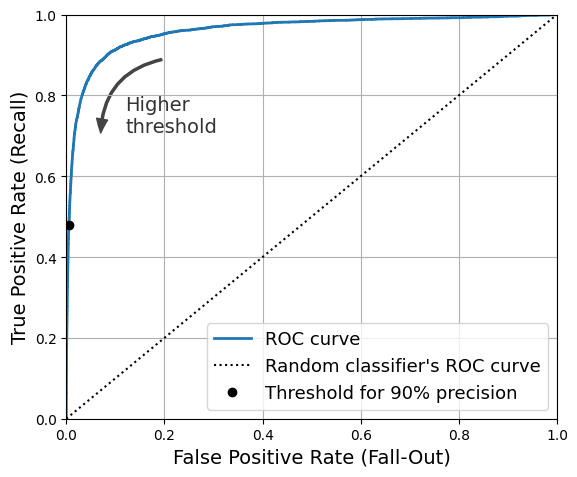

In [ ]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # 추가 코드
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# 추가 코드 – 그림 3–7을 그리고 저장합니다
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [ ]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

이는 _추정 확률(estimated probabilities)_입니다. 모델이 50%에서 60% 사이의 확률로 양성으로 분류한 이미지 중 실제로는 약 94%의 양성 이미지가 있습니다:

In [ ]:
# 책에는 없음
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [ ]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

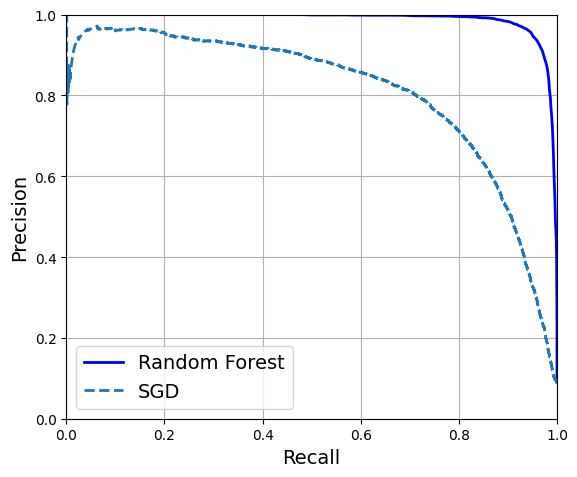

In [ ]:
plt.figure(figsize=(6, 5))  # 추가 코드

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# 추가 코드 – 그림 3–8을 그리고 저장합니다
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

`cross_val_predict(forest_clf, X_train, y_train_5, cv=3)`을 호출하여 `y_train_pred_forest`을 계산할 수 있습니다.
하지만 이미 추정 확률을 가지고 있기 때문에 기본 50% 임곗값과 비교하면 훨씬 빠르게 예측을 얻을 수 있습니다:

In [ ]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # 양성 확률 ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

# 다중 분류

SVM은 대용량 데이터셋에 잘 맞지 않기 때문에 처음 2,000개의 샘플만 사용해 훈련합니다. 그렇지 않으면 아주 오랜 시간이 걸립니다:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train_5가 아니고 y_train을 사용합니다.

SVC(random_state=42)

In [ ]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [ ]:
class_id = some_digit_scores.argmax()
class_id

5

In [ ]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [ ]:
svm_clf.classes_[class_id]

'5'

`decision_function()`이 45개 점수를 반환하게 하려면 `decision_function_shape` 매개변수를 `"ovo"`로 지정합니다. 기본값은 `"ovr"`이지만 혼동하지 마세요. `SVC`는 항상 OvO로 훈련합니다. 이 매개변수는 45개 점수를 반환할지 여부에만 영향을 미칩니다:

In [ ]:
# 추가 코드 – 45개 OvO 점수를 얻는 방법
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [ ]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [ ]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 에러 분석

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다.

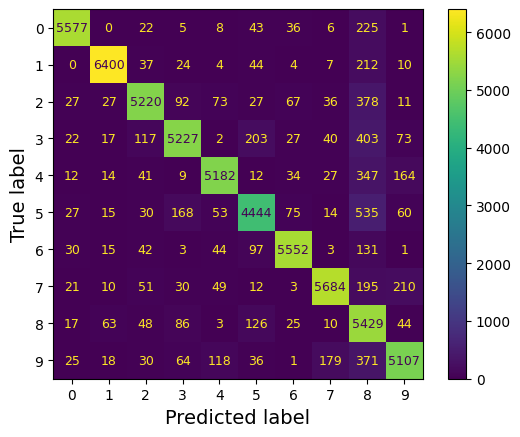

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # 추가 코드 - 폰트 크기를 줄입니다
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

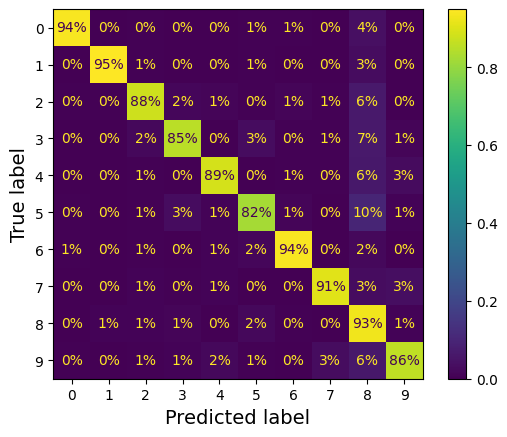

In [ ]:
plt.rc('font', size=10)  # 추가 코드
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

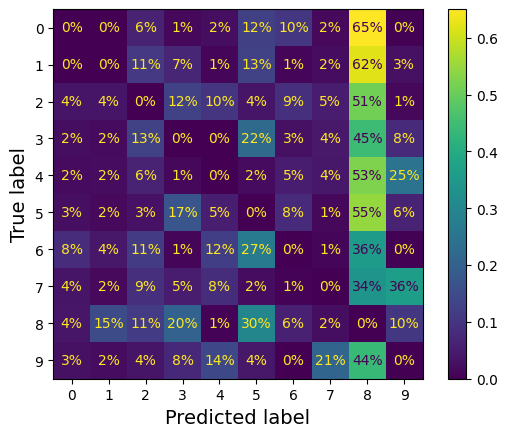

In [ ]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # 추가 코드
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

책에 있는 그래프를 그립니다:

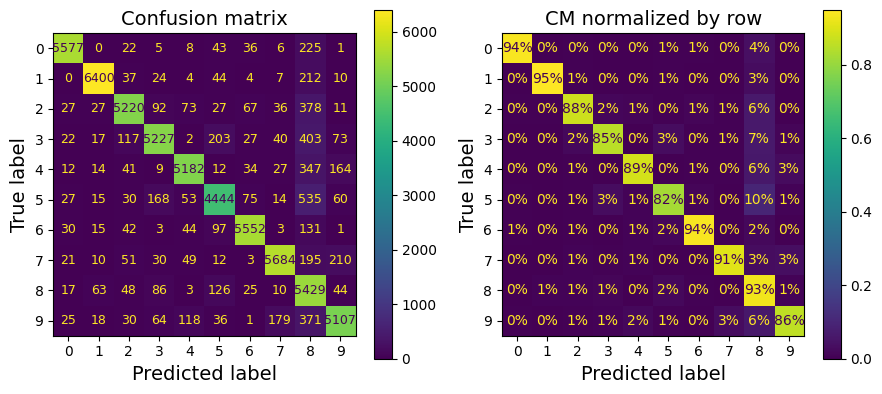

In [ ]:
# 추가 코드 – 그림 3–9을 생성하고 저장합니다
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

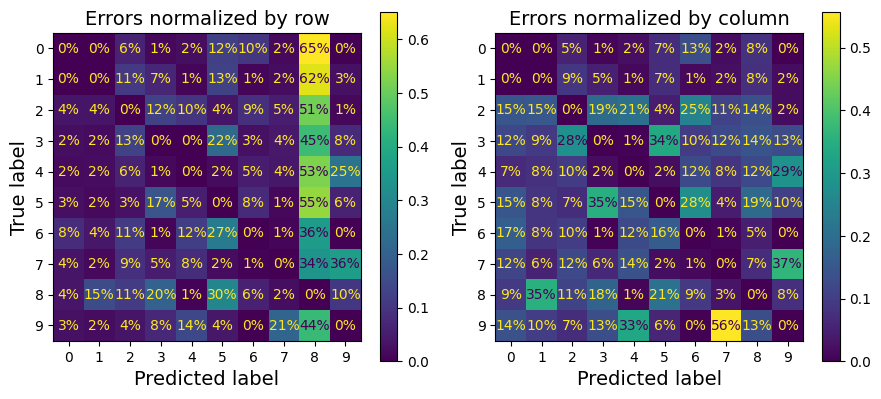

In [ ]:
# 추가 코드 – 그림 3–10을 생성하고 저장합니다
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # 폰트 크기를 다시 키웁니다

In [ ]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

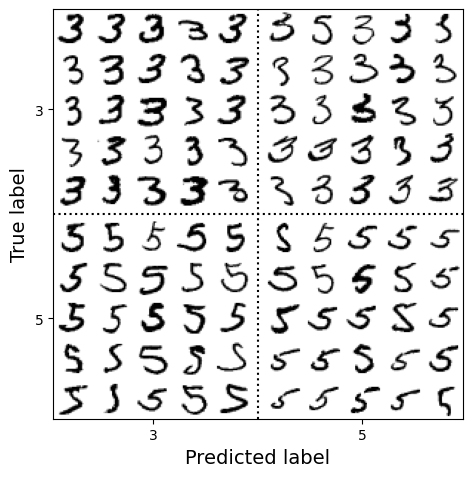

In [ ]:
# 추가 코드 – 그림 3–11을 생성하고 저장합니다
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

노트: 이와 같은 그래프를 그리는 방법이 여러 가지가 있지만 축 레이블을 올바르게 쓰기가 조금 어렵습니다:
* [nested GridSpecs](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html)
* 각 블록의 모든 숫자를 하나의 이미지로 합치기 (그다음 2x2 서브플롯 사용하기). 예를 들면:
    ```python
    X_aa[:25].reshape(5, 5, 28, 28).transpose(0, 2, 1, 3).reshape(5 * 28, 5 * 28)
    ```
* [subfigures](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html) (맷플롯립 3.4 이상)

# 다중 레이블 분류

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [ ]:
# 추가 코드 – average="weighted"로 지정했을 때 성능 향상은 무시할 수 있는 수준입니다.
#           이 클래스는 이미 꽤 균형 잡혀 있기 때문입니다.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [ ]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [ ]:
chain_clf.predict([some_digit])

array([[0., 1.]])

# 다중 출력 분류

In [ ]:
np.random.seed(42)  # 동일하게 재현되게 하려고 지정합니다
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

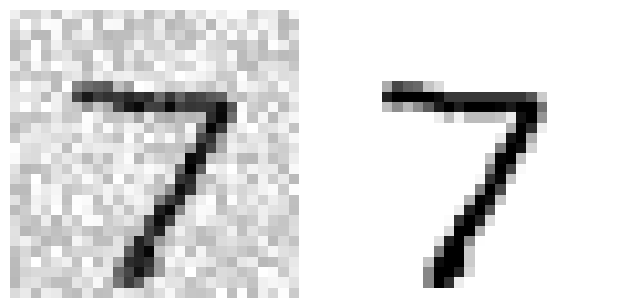

In [ ]:
# 추가 코드 – 그림 3–12을 생성하고 저장합니다
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

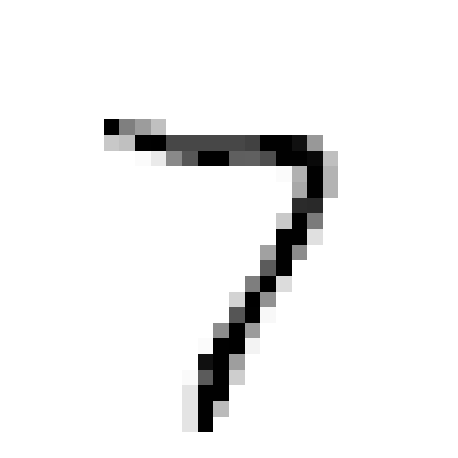

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # 추가 코드 – 그림 3–13을 저장합니다
plt.show()

# 연습문제 해답

## 1. 97% 정확도의 MNIST 분류기

문제: _MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97% 정확도를 달성해보세요. 힌트: `KNeighborsClassifier`가 이 작업에 아주 잘 맞습니다. 좋은 하이퍼파라미터 값만 찾으면 됩니다(`weights`와 `n_neighbors` 하이퍼파라미터로 그리드 탐색을 시도해보세요)._

K-최근접 이웃 분류기를 사용해 테스트 세트에서 성능을 측정해 보죠. 이 모델을 기준 모델로 삼습니다:

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

훌륭합니다! 기본 하이퍼파라미터를 사용하는 KNN 분류기는 우리 목표에 이미 매우 근접합니다.

하이퍼파라미터를 튜닝하면 도움이 될 수 있는지 살펴봅시다. 탐색 속도를 높이기 위해 처음 10,000개의 이미지에 대해서만 훈련해 보겠습니다:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [ ]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [ ]:
grid_search.best_score_

0.9441999999999998

점수가 떨어졌지만 10,000개의 이미지로만 훈련했기 때문에 예상했던 결과입니다. 이제 최상의 모델을 가져와 전체 훈련 세트에서 다시 훈련해 보겠습니다:

In [ ]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

97% 정확도 목표에 도달했습니다! 🥳

## 2. 데이터 증식

문제: _MNIST 이미지를 (왼, 오른, 위, 아래) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수를 만들어보세요. `scipy.ndimage.interpolation` 모듈의 `shift()` 함수를 사용할 수 있습니다. 예를 들어 `shift(image, [2, 1], cval=0)`은 아래로 2픽셀, 오른쪽으로 1픽셀 이동시킵니다. 그런 다음 훈련 세트에 있는 각 이미지에 대해 네 개의 이동된 복사본(방향마다 한 개씩)을 만들어 훈련 세트에 추가하세요. 마지막으로 이 확장된 데이터셋에서 앞에서 찾은 최선의 모델을 훈련시키고 테스트 세트에서 정확도를 측정해보세요. 모델 성능이 더 높아졌는지 확인해보세요! 인위적으로 훈련 세트를 늘리는 이 기법을 _데이터 증식_ 또는 _훈련 세트 확장_(training set expansion)이라고 합니다._

각 이미지의 약간 변형된 버전을 추가하여 MNIST 데이터셋을 증식해 보겠습니다.

In [ ]:
from scipy.ndimage import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

작동하는지 확인해 보겠습니다:

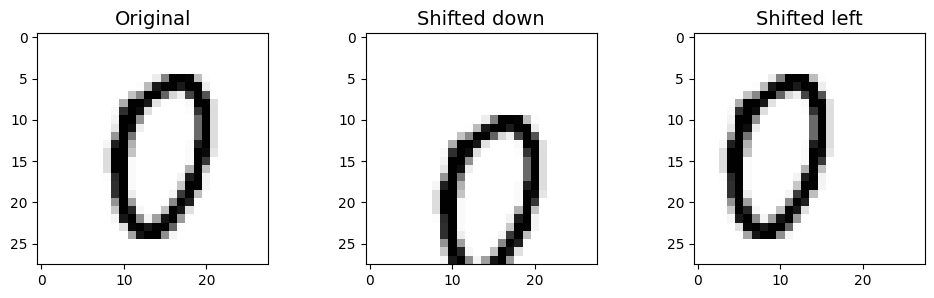

In [ ]:
image = X_train[1000]  # 데모에 사용할 임의의 숫자
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

좋아 보이네요! 이제 모든 이미지를 왼쪽, 오른쪽, 위, 아래로 1픽셀씩 이동하여 증식된 훈련 세트를 만들어 보겠습니다:

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

증식된 훈련 세트를 섞어 보겠습니다. 그렇지 않으면 이동된 모든 이미지가 함께 묶입니다:

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

이제 이전 연습문제에서 찾은 최상의 하이퍼파라미터를 사용하여 모델을 훈련해 보겠습니다:

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

**경고**: 다음 셀을 실행하는 데 몇 분 정도 걸릴 수 있습니다:

In [ ]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

단순히 데이터를 보강하는 것만으로도 정확도가 0.5% 향상되었습니다. 그다지 인상적으로 들리지 않을 수도 있지만 실제로는 오류율이 크게 감소했음을 의미합니다:

In [ ]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%


데이터 증식 덕분에 오류율이 상당히 감소했습니다.

## 3. 타이타닉 데이터셋 도전하기

문제: _타이타닉(Titanic) 데이터셋에 도전해보세요. [캐글](https://www.kaggle.com/c/titanic)이 시작하기 좋습니다. 또는 https://homl.info/titanic.tgz 에서 데이터를 다운로드하고, 2장의 주택 데이터에서 했던 것처럼 이 파일의 압축을 풀 수 있습니다. 이렇게 하면 CSV 파일 train.csv와 test.csv가 두 개가 생성되며, 이 파일을 `pandas.read_csv()`를 사용해 로드할 수 있습니다. 다른 열을 기반으로 `Survived` 열을 예측할 수 있는 분류기를 훈련하는 것이 목표입니다._

데이터를 가져와서 로드해 보겠습니다:

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [ ]:
train_data, test_data = load_titanic_data()

이 데이터는 이미 훈련 세트와 테스트 세트로 분할되어 있습니다. 하지만 테스트 데이터에는 레이블이 포함되어 있지 않습니다. 목표는 훈련 데이터에서 최상의 모델을 훈련한 다음, 테스트 데이터에서 예측을 만들고 캐글에 업로드하여 최종 점수를 확인하는 것입니다.

훈련 세트의 상위 몇 줄을 살펴봅시다:

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


특성은 다음과 같은 의미를 갖습니다:
* **PassengerId**: 각 승객의 고유 식별자
* **Survived**: 타깃입니다. 0은 승객이 생존하지 못했음을 의미하고, 1은 생존했음을 의미합니다.
* **Pclass**: 객실 등급.
* **Name**, **Sex**, **Age**: 설명이 필요 없는 특성
* **SibSp**: 타이타닉 호에 탑승한 승객의 형제자매 및 배우자 수.
* **Parch**: 타이타닉에 탑승한 승객의 자녀 및 부모 수.
* **Ticket**: 티켓 ID
* **Fare**: 지불한 가격(파운드)
* **Cabin**: 승객의 객실 번호
* **Embarked**: 승객이 타이타닉 호에 승선한 장소

승객의 나이, 성별, 객실 등급, 탑승 장소 등의 특성을 기반으로 승객의 생존 여부를 예측하는 것이 목표입니다.

명시적으로 `PassengerId` 열을 인덱스 열로 설정해 보겠습니다:

In [ ]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

누락된 데이터의 양을 확인하기 위해 자세한 정보를 확인해 보겠습니다:

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
train_data[train_data["Sex"]=="female"]["Age"].median()

27.0

**Age**, **Cabin** 및 **Embarked** 특성은 (891개 non-null이 아니기 때문에) 때때로 null입니다. 특히 **Cabin**(77%가 null)이 그렇습니다. 지금은 **Cabin**은 무시하고 나머지에 집중하겠습니다. **Age** 특성에는 약 19%의 null 값이 있으므로 이를 어떻게 처리할지 결정해야 합니다. null 값을 평균 연령으로 대체하는 것이 합리적입니다. 다른 열을 기반으로 나이를 예측하면 좀 더 스마트할 수 있지만(예를 들어, 1등급 객실의 나이 중앙값은 37세, 2등급은 29세, 3등급은 24세), 여기서는 간단하게 전체 중앙값을 사용하기로 하겠습니다.

**Name** 및 **Ticket** 특성은 어느 정도 가치가 있을 수 있지만 모델이 사용할 수 있는 유용한 숫자로 변환하기에는 약간 까다롭습니다. 따라서 지금은 무시하겠습니다.

숫자 특성을 살펴보겠습니다:

In [ ]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 이런, **Survived**가 38%뿐입니다! 😭 40%에 충분히 근접한 수치이므로 정확도는 모델을 평가하는 합리적인 지표가 될 것입니다.
* 평균 **Fare**는 32.20파운드로 그렇게 비싸지 않은 것 같습니다(하지만 그 당시에는 많은 돈이었을 것입니다).
* 평균 **Age**는 30세 미만이었습니다.

타깃이 실제로 0 또는 1인지 확인해 보겠습니다:

In [ ]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

이제 모든 범주형 특성에 대해 간단히 살펴보겠습니다:

In [ ]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [ ]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [ ]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

승선 위치 특성은 승객이 승선한 위치를 알려줍니다: C=Cherbourg, Q=Queenstown, S=Southampton.

이제 숫자 특성에 대한 파이프라인부터 시작하여 전처리 파이프라인을 구축해 보겠습니다:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

이제 범주형 특성에 대한 파이프라인을 구축할 수 있습니다:

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [ ]:
# 사이킷런 1.2버전에서 OneHotEncoder의 `sparse_output` 매개변수가 추가되었고
# `sparse` 매개변수는 1.4버전에서 삭제되었습니다.
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

마지막으로 숫자 파이프라인과 범주 파이프라인을 결합해 보겠습니다:

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

멋지네요! 이제 원시 데이터를 가져와 원하는 머신 러닝 모델에 공급 가능한 수치 입력 특성을 출력하는 멋진 전처리 파이프라인이 생겼습니다.

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

레이블을 챙기는 것도 잊지 마세요:

In [ ]:
y_train = train_data["Survived"]

이제 분류기를 훈련할 준비가 되었습니다. 먼저 `RandomForestClassifier`로 시작해 보죠:

In [ ]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

모델이 학습되었으니 이제 이 모델을 사용하여 테스트 세트에 대한 예측을 수행해 보겠습니다:

In [ ]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

이제 이러한 예측이 포함된 CSV 파일을 (캐글이 기대하는 형식에 맞추어) 작성한 다음 업로드하고 최선이기를 바랄 수 있습니다. 하지만 잠깐만요! 그냥 희망하는 것보다 더 좋은 방법이 있습니다. 교차 검증을 사용하여 모델이 얼마나 좋은지 알아보는 것은 어떨까요?

In [ ]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

좋아요, 나쁘지 않네요! 캐글에서 타이타닉 대회의 [리더보드](https://www.kaggle.com/c/titanic/leaderboard)를 보면, 이 점수가 상위 2%에 속하는 것을 확인할 수 있습니다, 우후! 100% 정확도를 달성한 캐글러도 있었지만, 타이타닉의 [희생자 명단](https://www.encyclopedia-titanica.org/titanic-victims/)을 쉽게 찾아볼 수 있는 것으로 보아 머신러닝의 영향이 거의 없었던 것 같습니다! 😆

`SVC`를 시도해 보죠:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

좋아요! 이 모델이 더 좋아 보입니다.

하지만 10개의 교차 검증 폴드에 대한 평균 정확도만 보는 대신 각 모델에 대한 10개의 모든 점수를 하위 및 상위 사분위수를 강조하는 박스 플롯과 점수의 범위를 보여주는 '수염'을 함께 그려 보겠습니다(이 시각화를 제안해 준 Nevin Yilmaz에게 감사드립니다). `boxplot()` 함수는 이상치을 감지하며 수염에는 포함하지 않는다는 점에 유의하세요. 구체적으로, 하위 사분위수가 $Q_1$이고 상위 사분위수가 $Q_3$인 경우 사분위수 간 범위가 $IQR = Q_3 - Q_1$(상자의 높이)이며, $Q_1 - 1.5 \times IQR$보다 낮은 점수는 이상치이고, $Q3 + 1.5 \times IQR$보다 큰 점수도 이상치에 해당합니다.

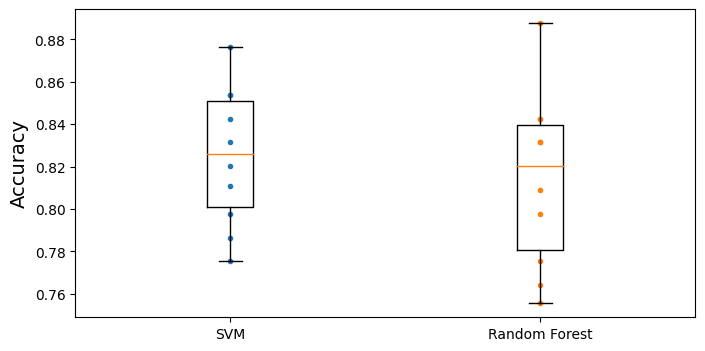

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

랜덤 포레스트 분류기는 10개 폴드 중 하나에서 매우 높은 점수를 받았지만 전반적으로 평균 점수가 낮고 더 널리 퍼져 있어서 SVM 분류기가 더 잘 일반화할 가능성이 높은 것으로 보입니다.

이 결과를 더욱 개선하려면 다음과 같이 할 수 있습니다:
* 교차 검증 및 그리드 검색을 사용하여 더 많은 모델을 비교하고 하이퍼파라미터를 조정하세요.
* 더 많은 특성 공학을 수행하세요. 예를 들면 다음과 같습니다:
  * 숫자 특성을 범주 특성으로 변환해 보세요. 예를 들어, 연령대별로 생존율이 매우 다르므로(아래 참조) 연령 버킷 카테고리를 만들어 연령 대신 사용하는 것이 도움이 될 수 있습니다. 마찬가지로, 혼자 여행하는 사람들의 생존율이 30%에 불과했기 때문에 혼자 여행하는 사람들을 위한 특별 카테고리를 만드는 것이 유용할 수 있습니다(아래 참조).
  * **SibSp**와 **Parch**를 합쳐 보세요.
  * **Survived** 속성과 잘 연관되는 이름 부분을 찾아보세요.
  * **Cabin** 열을 사용하세요. 예를 들어 첫 글자를 가져와 범주형 속성으로 처리합니다.

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 4. 스팸 필터

문제: _스팸 분류기를 만들어보세요(아주 도전적인 과제입니다)._

* _[아파치 스팸어새신(Apache SpamAssassin) 공공 데이터셋](https://homl.info/spamassassin)에서 스팸(spam)과 햄(ham)(스팸이 아닌 메일) 샘플을 내려받습니다._
* _데이터셋의 압축을 풀고 데이터 형식을 살펴봅니다._
* _데이터셋을 훈련 세트와 테스트 세트로 나눕니다._
* _각 이메일을 특성 벡터로 변환하는 데이터 준비 파이프라인을 만듭니다. 이 준비 파이프라인은 하나의 이메일을 가능한 단어의 존재 여부를 나타내는 (희소) 벡터로 바꿔야 합니다. 예를 들어 모든 이메일이 네 개의 단어 ‘Hello’, ‘how’, ‘are’, ‘you’만 포함한다면 ‘Hello you Hello Hello you’란 이메일은 벡터 [1, 0, 0, 1]([‘Hello’ 있음, ‘how’ 없음, ‘are’ 없음, ‘you’ 있음]을 의미)로 변환되거나, 단어의 출현 횟수에 관심이 있다면 [3, 0, 0, 2]로 변환되어야 합니다._


_준비 파이프라인에 이메일 헤더 제거, 소문자 변환, 구두점 제거, 모든 URLs 주소를 ‘URL’로 대체, 모든 숫자를 ‘NUMBER’로 대체, 어간stem 추출20(즉, 단어의 끝을 떼어냅니다. 이런 작업을 할 수 있는 파이썬 라이브러리가 있습니다) 등을 수행할지 여부를 제어하기 위해 하이퍼파라미터를 추가합니다._

_마지막으로 여러 분류기를 시도해보고 재현율과 정밀도가 모두 높은 스팸 분류기를 만들 수 있는지 확인해보세요._

In [ ]:
import tarfile

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [ ]:
ham_dir, spam_dir = fetch_spam_data()

다음, 모든 이메일을 읽어 들입니다:

In [ ]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [ ]:
len(ham_filenames)

2500

In [ ]:
len(spam_filenames)

500

파이썬의 `email` 모듈을 사용해 이메일을 파싱합니다(헤더, 인코딩 등을 처리합니다):

In [ ]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [ ]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

데이터가 어떻게 구성되어 있는지 감을 잡기 위해 햄 메일과 스팸 메일을 하나씩 보겠습니다:

In [ ]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [ ]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


어떤 이메일은 이미지나 첨부 파일을 가진 멀티파트(multipart)입니다(메일에 포함되어 있을수 있습니다). 어떤 파일들이 있는지 살펴 보겠습니다:

In [ ]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [ ]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [ ]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [ ]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

햄 메일은 평범한 텍스트가 많고 스팸은 HTML일 경우가 많습니다. 적은 수의 햄 이메일이 PGP로 서명되어 있지만 스팸 메일에는 없습니다. 요약하면 이메일 구조는 유용한 정보입니다.

이제 이메일 헤더를 살펴보겠습니다:

In [ ]:
for header, value in spam_emails[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

보낸사람의 이메일 주소와 같이 헤더에는 유용한 정보가 많이 있지만 여기서는 `Subject` 헤더만 다뤄 보겠습니다:

In [ ]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

좋습니다. 데이터에를 더 살펴보기 전에 훈련 세트와 테스트 세트로 나누도록 하겠습니다:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

이제 전처리 함수를 작성하겠습니다. 먼저 HTML을 일반 텍스트로 변환하는 함수가 필요합니다. 이 작업에는 당연히 [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) 라이브러리를 사용하는게 좋지만 의존성을 줄이기 위해서 정규식을 사용하여 대강 만들어 보겠습니다([un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)의 위험에도 불구하고). 다음 함수는 `<head>` 섹션을 삭제하고 모든 `<a>` 태그를 HYPERLINK 문자로 바꿉니다. 그런 다음 모든 HTML 태그를 제거하고 텍스트만 남깁니다. 보기 편하게 여러개의 개행 문자를 하나로 만들고 (`&gt;`나 `&nbsp;` 같은) html 엔티티를 복원합니다:

In [ ]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

잘 작동하는지 확인해 보겠습니다. 다음은 HTML 스팸입니다:

In [ ]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

변환된 텍스트입니다:

In [ ]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

아주 좋습니다! 이제 포맷에 상관없이 이메일을 입력으로 받아서 일반 텍스트를 출력하는 함수를 만들겠습니다:

In [ ]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [ ]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


자연어 처리 툴킷([NLTK](http://www.nltk.org/))을 사용해 어간 추출을 해보죠:

In [ ]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


인터넷 주소는 "URL" 문자로 바꾸겠습니다. [정규식](https://mathiasbynens.be/demo/url-regex)을 하드 코딩할 수도 있지만 [urlextract](https://github.com/lipoja/URLExtract) 라이브러리를 사용하겠습니다:

In [ ]:
# 코랩이나 캐글을 사용하나요?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# 코랩이나 캐글에서 이 노트북을 실행하려면 먼저 pip install urlextract을 실행합니다
if IS_COLAB or IS_KAGGLE:
    %pip install -q -U urlextract

**노트:** 주피터 노트북에서는 항상 `!pip` 대신 `%pip`를 사용해야 합니다. `!pip`는 다른 환경에 라이브러리를 설치할 수 있기 때문입니다. 반면 `%pip`는 현재 실행 중인 환경에 설치됩니다.

In [ ]:
import urlextract # 루트 도메인 이름을 다운로드하기 위해 인터넷 연결이 필요할지 모릅니다

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


이들을 모두 하나의 변환기로 연결하여 이메일을 단어 카운트로 바꿀 것입니다. 파이썬의 `split()` 메서드를 사용하면 구둣점과 단어 경계를 기준으로 문장을 단어로 바꿉니다. 이 방법이 많은 언어에 통하지만 전부는 아닙니다. 예를 들어 중국어와 일본어는 일반적으로 단어 사이에 공백을 두지 않습니다. 베트남어는 음절 사이에 공백을 두기도 합니다. 여기서는 데이터셋이 (거의) 영어로 되어 있기 때문에 문제없습니다.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

이 변환기를 몇 개의 이메일에 적용해 보겠습니다:

In [ ]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

제대로 작동하는 것 같네요!

이제 단어 카운트를 벡터로 변환해야 합니다. 이를 위해서 또 다른 변환기를 만들겠습니다. 이 변환기는 (자주 나타나는 단어 순으로 정렬된) 어휘 목록을 구축하는 `fit()` 메서드와 어휘 목록을 사용해 단어를 벡터로 바꾸는 `transform()` 메서드를 가집니다. 출력은 희소 행렬이 됩니다.

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [ ]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [ ]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]])

이 행렬은 무엇을 의미하나요? 세 번째 행의 첫 번째 열의 65는 세 번째 이메일이 어휘 목록에 없는 단어를 65개 가지고 있다는 뜻입니다. 그 다음의 0은 어휘 목록에 있는 첫 번째 단어가 한 번도 등장하지 않는다는 뜻이고 그 다음의 1은 한 번 나타난다는 뜻입니다. 이 단어들이 무엇인지 확인하려면 어휘 목록을 보면 됩니다. 첫 번째 단어는 "the"이고 두 번째 단어는 "of"입니다.

In [ ]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

이제 스팸 분류기를 훈련시킬 준비를 마쳤습니다! 전체 데이터셋을 변환시켜보죠:

In [ ]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

0.985

98.5%가 넘네요. 첫 번째 시도치고 나쁘지 않습니다! :) 그러나 이 데이터셋은 비교적 쉬운 문제입니다. 더 어려운 데이터셋에 적용해 보면 결과가 그리 높지 않을 것입니다. 여러개의 모델을 시도해 보고 제일 좋은 것을 골라 교차 검증으로 세밀하게 튜닝해 보세요.

하지만 전체 내용을 파악했으므로 여기서 멈추겠습니다. 테스트 세트에서 정밀도/재현율을 출력해 보겠습니다:

In [ ]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 96.88%
Recall: 97.89%
